# ET0 Exploratory Data Analysis

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import folium

import os
import glob

## Loading data

In [19]:
# Enter path to the directory containing processed data
# path/to/processed/data

path_to_dir = r'C:\Users\HP\Desktop\Git\evapotranspiration\processed_data'

In [20]:
file_name = 'ET0_data.csv'
path = os.path.join(path_to_dir, file_name)

df = pd.read_csv(path)

## Functions

In [21]:
def plot_map(stations,
             color='blue',
             path_to_st_def = r"C:\Users\HP\Desktop\Git\evapotranspiration\processed_data\station_definitions.csv"):
    
    
    
    tiles = 'https://stamen-tiles-{s}.a.ssl.fastly.net/terrain-background/{z}/{x}/{y}{r}.png'
    attr = 'Map tiles by <a href="http://stamen.com">Stamen Design</a>, <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a> &mdash; Map data &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
    location = [37.5, 28.5]
    zoom = 8
    marker_radius = 3
    
    # Loading station definitions
    st_def = pd.read_csv(path_to_st_def)[['st_num', 'latitude', 'longitude', 'elevation']]

    # Merging station definitions with station scores
    cond = st_def['st_num'].isin(stations)
    df = st_def.loc[cond].reset_index(drop=True)
    
    m = folium.Map(location = location, zoom_start = zoom, tiles = tiles, attr = attr)


    for row in df.iterrows():
        row = row[1]

        # Location of station
        loc = [row['latitude'], row['longitude']]

        # Text in pop-up
        txt = ''
        txt += '<h5><b>Station: {}\n</h5></b>'.format(int(row['st_num']))
        txt += 'Elevation: {} m'.format(row['elevation'])
        popup = folium.Popup(txt, min_width = 100, max_width = 100)
        folium.CircleMarker(location = loc,
                            fill = True,
                            fill_opacity = 0.8,
                            opacity = 1,
                            color = color,
                            radius = marker_radius
                            ).add_child(popup).add_to(m)

    display(m)

    return m

In [24]:
def plot_scatter(x, y, ax=None, size=(8, 6), label=None, color='limegreen'):
    '''
    Function to create a scatter plot
    '''
    if ax is None:
        fig, ax = plt.subplots(figsize=size)
    
    ax.scatter(x=x, y=y, color=color, label=label, edgecolor='white', linewidth=0.5)
    
    return ax

In [47]:
def corr_heatmap(data, figsize=(8, 8)):
    '''
    Create a correlation heatmap with square sizes varying according to the absolute correlation value.
    Code based on: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
    '''
    
    import seaborn as sns
    from matplotlib.cm import ScalarMappable
    from matplotlib.colors import Normalize


    # Size scale 
    size_scale = 500
    
    # Color map
    palette = sns.diverging_palette(20, 220, as_cmap=True)
    
    
    # Computing correlations
    corr = data.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    
    x = corr['x']
    y = corr['y']
    size = corr['value'].abs()
    color = corr['value']

    fig, ax = plt.subplots(figsize=figsize)
    
    dim = data.shape[1]
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    
    # y-ticks are inverted to put the identical values on the main diagonal
    y_to_num = {p[1]:-p[0] for p in enumerate(y_labels)}
    num_to_y = {val:key for key, val in y_to_num.items()}
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s', # Use square as scatterplot marker
        c=color,
        cmap=palette)
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')

    yticks = np.sort([y_to_num[v] for v in y_labels])
    ax.set_yticks(yticks)
    ax.set_yticklabels([num_to_y[i] for i in yticks])
    
    # Setting minor ticks to create the grid
    ax.grid(False, 'major')
    ax.grid(True, 'minor', color='w', lw=2)
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t - 0.5 for t in ax.get_yticks()], minor=True)
    
    ax.set_xlim(-0.5, ax.get_xticks(minor=True)[-1])
    ax.set_ylim(ax.get_yticks(minor=True)[0], 0.5)
    
    ax.set_facecolor('#F4F4F4')
    
    for side in ['left', 'right', 'top', 'bottom']:
        ax.spines[side].set_visible(False)
        
    ax.tick_params(left=False, which='both')
    ax.tick_params(bottom=False, which='both')
    
    cmappable = ScalarMappable(norm=Normalize(-1,1), cmap=palette)
    cb = plt.colorbar(cmappable, ticks=[-1, 0, 1])
    
    # Hiding colorbar outline
    cb.outline.set_visible(False)
    
    return ax

In [27]:
def plot_corr(data, variables, figsize=(16, 6)):
    
    '''
    Create a scatter matrix of the first n_components PCs plotted against each other
    '''

    fig, axs = plt.subplots(1, len(variables), figsize=figsize)
    
    
    flag = 0
    
    for ax, variable in zip(axs, variables):


        x = data[variable]
        y = data['ET0']

        plot_scatter(x, y, ax=ax)
        
        if flag == 0:
            ax.set_ylabel('ET0')
            flag = 1
            
        ax.set_title(variable.replace('_', ' ').title())

In [38]:
def plot_var_dist(df,
                  color='skyblue',
                  bins=25,
                  figsize = (14, 14)):
    
    '''
    Plots histograms of the following variables:
    ['Average Temperature', 'Maximum Temperature', 'Average Humidity',
              'Wind Speed', 'Solar Radiation', 'FAO-56 PM ET0']
    '''
    
    fig, axs = plt.subplots(3, 2, constrained_layout = True, figsize = (14, 14))
    
    fig.suptitle('Variable Distributions\n', fontsize = 20)
    axs = axs.flatten()
    
    var_list = ['avg_temp', 'max_temp', 'avg_hum', 'avg_ws', 'inc_rad', 'ET0']

    titles = ['Average Temperature', 'Maximum Temperature', 'Average Humidity',
              'Wind Speed', 'Solar Radiation', 'FAO-56 PM ET0']

    alpha = 0.6

    for i, var in enumerate(var_list):
        
        ax = axs[i]
        
        count, edges = np.histogram(df[var], bins = bins)
        labels = list(map(lambda x: '{:.1f}'.format(x), edges))
        
        ax.hist(df[var], bins = edges, edgecolor = 'w', alpha = alpha, color = color)
        
        ax.set_xticks(ticks = edges)
        ax.set_xticklabels(labels, rotation = 'vertical')
        ax.set_title(titles[i])

    plt.show()

## Station locations on map

In [22]:
stations = df['st_num'].unique()

![alt text](map_img.png "Title")

In [29]:
m = plot_map(stations)

## Correlations

**Correlation heatmap**: The size of squares represents the magnitude of correlation (negative or positive)

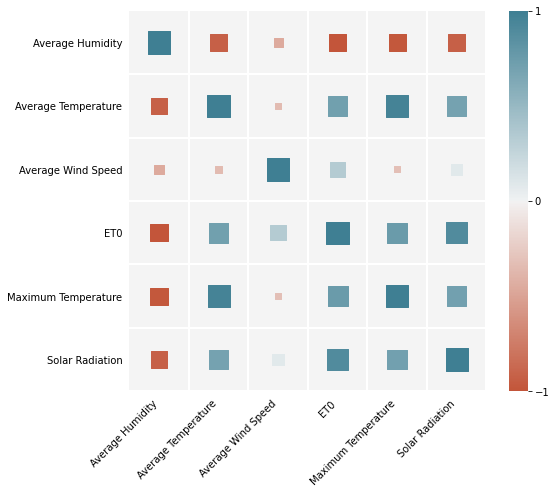

In [50]:
cols = ['max_temp', 'avg_temp', 'inc_rad', 'avg_hum', 'avg_ws', 'ET0']

data = df[cols]

new_cols = ['Maximum Temperature', 'Average Temperature', 'Solar Radiation', 'Average Humidity', 'Average Wind Speed', 'ET0']

col_repl = dict(zip(cols, new_cols))

data = data.rename(columns=col_repl)

ax = corr_heatmap(data, figsize=(8, 7))

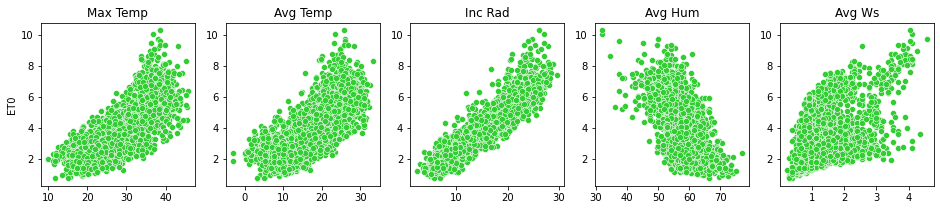

In [28]:
variables = ['max_temp', 'avg_temp', 'inc_rad', 'avg_hum', 'avg_ws']
plot_corr(df, variables, figsize=(16, 3))

## Variable Distributions

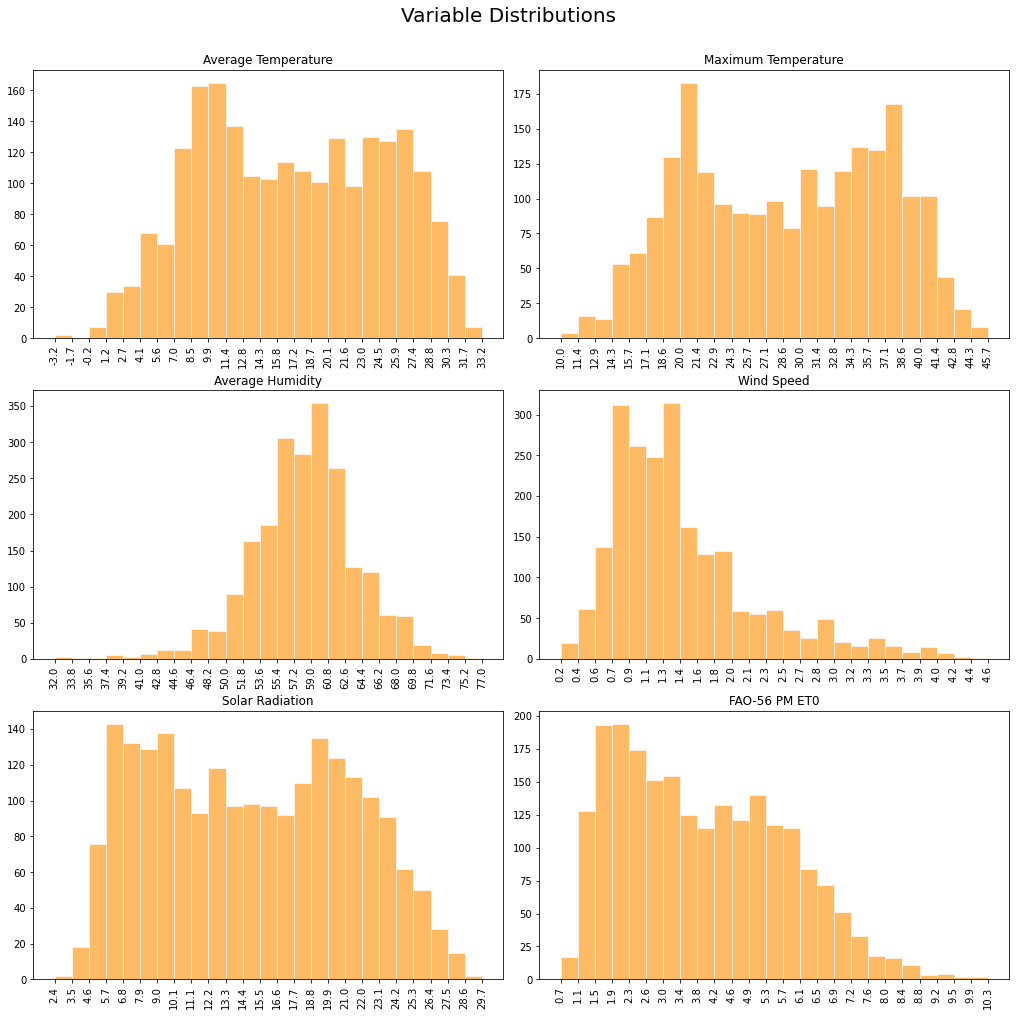

In [46]:
plot_var_dist(df, color='darkorange')